# Dogs vs Cats Redux
Kaggle competition and first homework assignment from fastai MOOC. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path

In [3]:
bs = 32

In [4]:
path = Path('../data/dogs-vs-cats-redux-kernels-edition/')
path_train = path/'train'
path_test = path/'test'

In [33]:
data = ImageDataBunch.from_folder(path, train="train", test="test", valid_pct=0.2,
                                  classes=['cat', 'dog'],
                                  ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

/home/kai/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
test
  if getattr(ds, 'warn', False): warn(ds.warn)
/home/kai/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
test
  if getattr(ds, 'warn', False): warn(ds.warn)


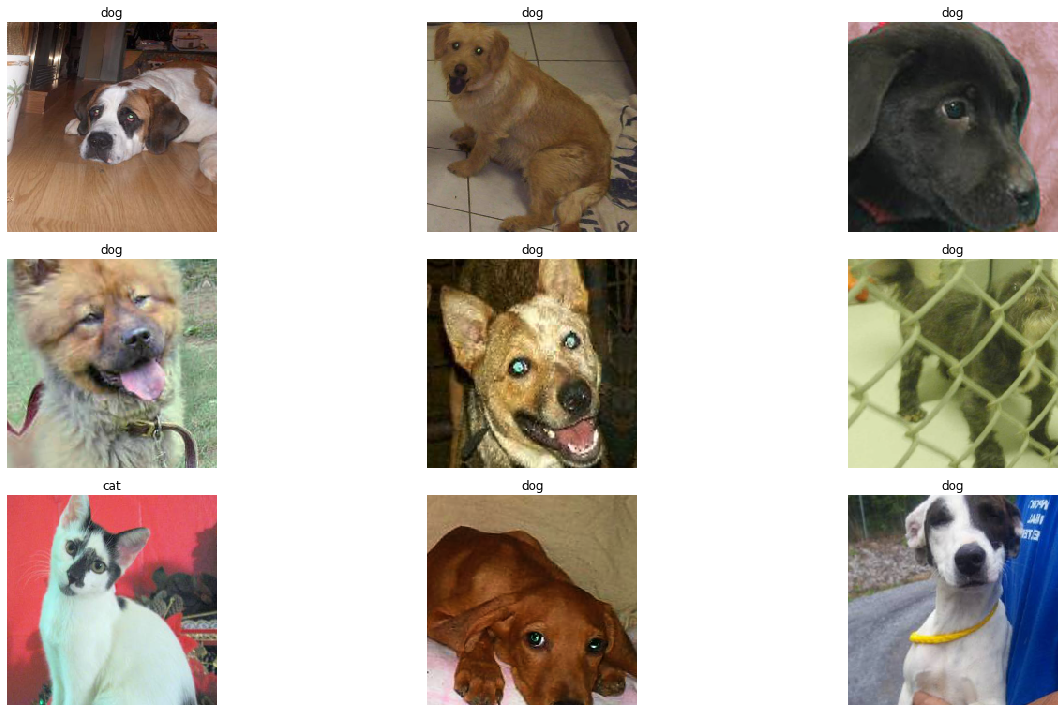

In [34]:
data.show_batch(rows=3, figsize=(20, 10))

In [106]:
print(data.classes)
len(data.classes), data.c

['cat', 'dog']


(2, 2)

In [115]:
data

ImageDataBunch;

Train: LabelList (19956 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dog,dog,dog,dog,dog
Path: ../data/dogs-vs-cats-redux-kernels-edition;

Valid: LabelList (5044 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dog,dog,cat,cat,dog
Path: ../data/dogs-vs-cats-redux-kernels-edition;

Test: LabelList (12500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../data/dogs-vs-cats-redux-kernels-edition

## Model Fitting

### Questions
- When fitting a model initially, do we choose the learning rate from `lr_find` first or just fit without that?

In [116]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


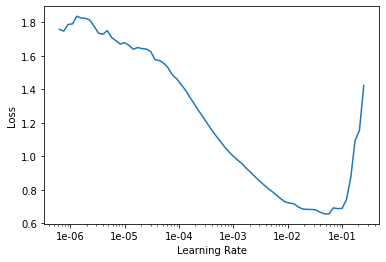

In [117]:
learn.lr_find()
learn.recorder.plot()

In [118]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.126332,0.052677,0.982355,0.017645,01:36
1,0.075831,0.035260,0.987113,0.012887,01:36
2,0.070182,0.025206,0.992268,0.007732,01:35
3,0.040819,0.025986,0.990682,0.009318,01:36
4,0.037548,0.021522,0.993061,0.006939,01:36
5,0.033508,0.020874,0.992466,0.007534,01:35
6,0.023154,0.020010,0.993259,0.006741,01:36
7,0.019225,0.020647,0.992070,0.007930,01:36


In [119]:
learn.save('stage-1')

In [120]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.147659,0.064047,0.977002,0.022998,02:06
1,0.079174,0.976593,0.985726,0.014274,02:07
2,0.038599,0.024993,0.991277,0.008723,02:08


In [121]:
# it things turn out worse
# learn.load('stage-1')
learn.save('stage-2')

### Analyze Results and Fine-Tuning

In [122]:
interp = ClassificationInterpretation.from_learner(learn)

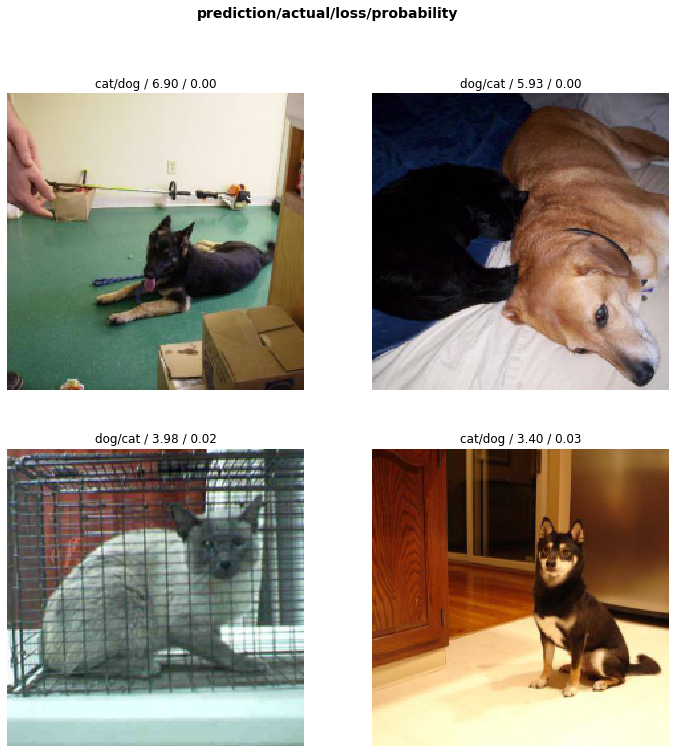

In [123]:
interp.plot_top_losses(4)

In [124]:
interp.most_confused(min_val=2)

[('cat', 'dog', 26), ('dog', 'cat', 18)]

In [125]:
# Since test set has no labels, y ends up with a bunch of zeroes.
preds, y = learn.get_preds(DatasetType.Test)

In [126]:
len(preds[1])

2

In [127]:
print(data.test_ds)

LabelList (12500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../data/dogs-vs-cats-redux-kernels-edition


In [128]:
test_nums = [int(str(i).split('/')[-1][:-4]) for i in data.test_dl.dataset.items]

In [129]:
dog_proba = [np.round(np.float(p), 2) for p in (np.clip(preds[:, 1], .02, .98))]

In [130]:
file = 'submission-2.csv'
with open(file, 'a') as f:
    for i, num in enumerate(test_nums):
        f.write(str(test_nums[i]) + ',' + str(dog_proba[i]) + '\n')